In [3]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, Input, Conv1D, MaxPooling1D, Flatten
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder




In [4]:
#loading data into dataframe
df = pd.read_csv('Desktop/FinalProjectPGAToutData.csv')

# Examining the first 5 rows of data
print(df.head())

      Player Name  Year  Rounds Played in Year  Average Fairway Percentage  \
0  Henrik Stenson  2018                     60                       75.19   
1     Ryan Armour  2018                    109                       73.58   
2     Chez Reavie  2018                     93                       72.24   
3      Ryan Moore  2018                     78                       71.94   
4    Brian Stuard  2018                    103                       71.44   

   Average Driving Distance  Average GIR  Average Putts  Average Scrambling  \
0                     291.5        73.51          29.93               60.67   
1                     283.5        68.22          29.31               60.13   
2                     286.5        68.67          29.12               62.27   
3                     289.2        68.80          29.17               64.16   
4                     278.9        67.12          29.11               59.23   

   Average Score  Average SG Putts  Average SG Total  SG

In [5]:
#looking at general data information
df.info

<bound method DataFrame.info of          Player Name  Year  Rounds Played in Year  Average Fairway Percentage  \
0     Henrik Stenson  2018                     60                       75.19   
1        Ryan Armour  2018                    109                       73.58   
2        Chez Reavie  2018                     93                       72.24   
3         Ryan Moore  2018                     78                       71.94   
4       Brian Stuard  2018                    103                       71.44   
...              ...   ...                    ...                         ...   
1673  Phil Mickelson  2010                     76                       52.66   
1674       John Daly  2010                     63                       52.21   
1675    Jimmy Walker  2010                     82                       51.29   
1676   Daniel Chopra  2010                     74                       51.27   
1677   Martin Flores  2010                     75                       50.15

In [6]:
#checking size of data from csv file
df.shape

(1678, 15)

In [7]:
# Chnaging all empty or non values to 0's and changing incorrect variable typings
df['Top 10 Placements'].fillna(0, inplace=True)
df['Top 10 Placements'] = df['Top 10 Placements'].astype(int)
df.dropna(axis = 0, inplace=True)
df['Rounds Played in Year'] = df['Rounds Played in Year'].astype(int)

ord_enc = OrdinalEncoder()
df["player_code"] = ord_enc.fit_transform(df[["Player Name"]])
df = df.drop(columns=['Player Name'])



In [8]:
#checking if changes to feature types are correct and whether any other chnages need to be made
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1678 entries, 0 to 1677
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Year                        1678 non-null   int64  
 1   Rounds Played in Year       1678 non-null   int32  
 2   Average Fairway Percentage  1678 non-null   float64
 3   Average Driving Distance    1678 non-null   float64
 4   Average GIR                 1678 non-null   float64
 5   Average Putts               1678 non-null   float64
 6   Average Scrambling          1678 non-null   float64
 7   Average Score               1678 non-null   float64
 8   Average SG Putts            1678 non-null   float64
 9   Average SG Total            1678 non-null   float64
 10  SG:OTT                      1678 non-null   float64
 11  SG:APR                      1678 non-null   float64
 12  SG:ARG                      1678 non-null   float64
 13  Top 10 Placements           1678 

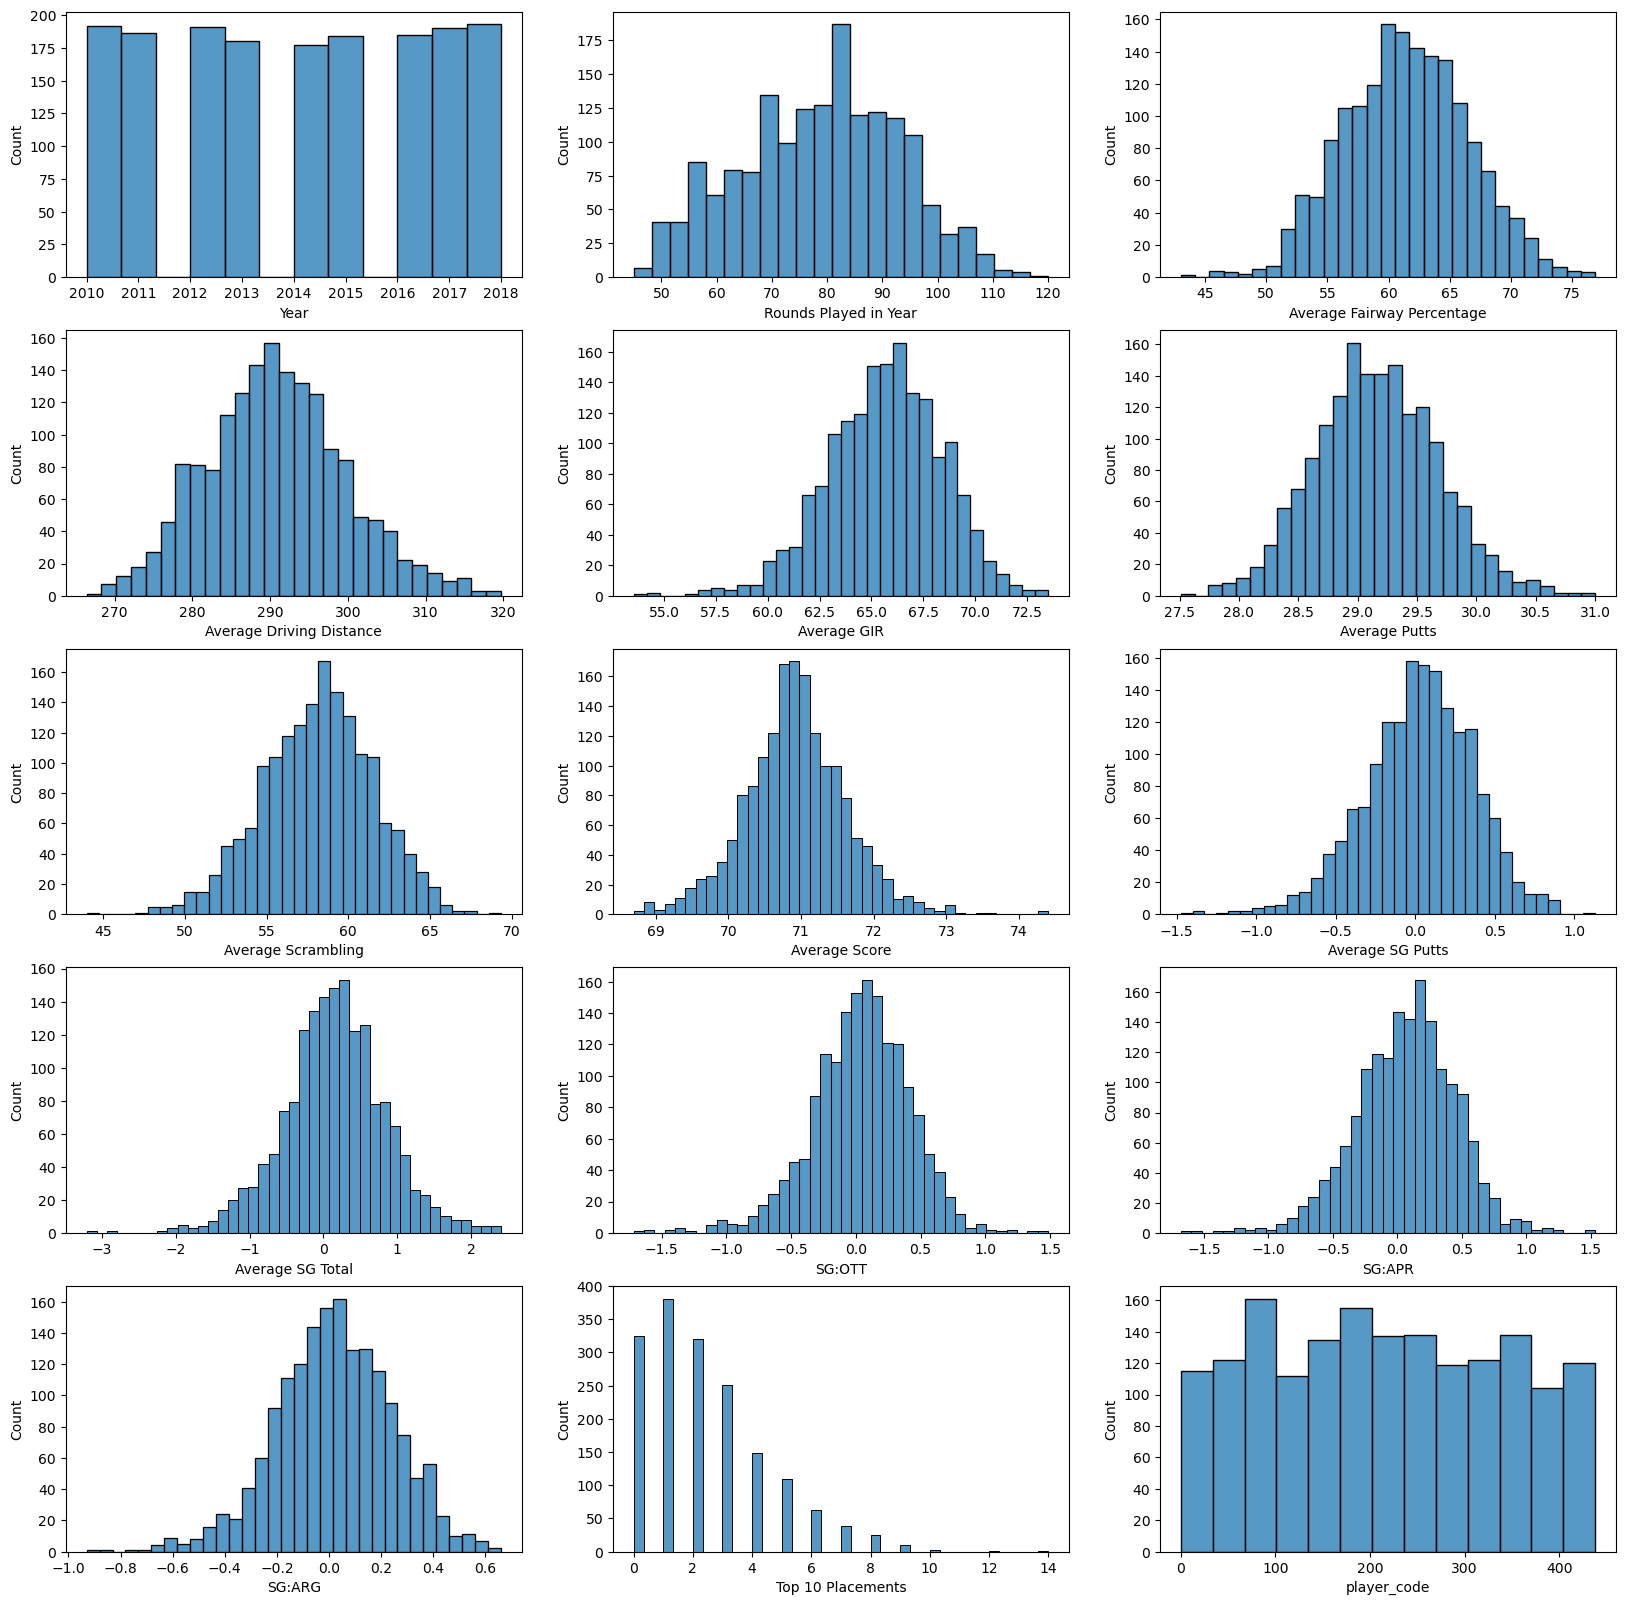

In [9]:
#data distribution
f, ax = plt.subplots(nrows = 5, ncols = 3, figsize=(20,20))
distribution = df.loc[:,df.columns!='Player Name'].columns
rows = 0
cols = 0
for i, column in enumerate(distribution):
    p = sns.histplot(df[column], ax=ax[rows][cols])
    cols += 1
    if cols == 3:
        cols = 0
        rows += 1

In [10]:
# Creating a definition for the players that had atleast one top 10 placement in a year
upperEchelonPlayers = df.loc[df['Top 10 Placements'] >= 1, :]
print(upperEchelonPlayers.head())

   Year  Rounds Played in Year  Average Fairway Percentage  \
0  2018                     60                       75.19   
1  2018                    109                       73.58   
2  2018                     93                       72.24   
3  2018                     78                       71.94   
4  2018                    103                       71.44   

   Average Driving Distance  Average GIR  Average Putts  Average Scrambling  \
0                     291.5        73.51          29.93               60.67   
1                     283.5        68.22          29.31               60.13   
2                     286.5        68.67          29.12               62.27   
3                     289.2        68.80          29.17               64.16   
4                     278.9        67.12          29.11               59.23   

   Average Score  Average SG Putts  Average SG Total  SG:OTT  SG:APR  SG:ARG  \
0         69.617            -0.207             1.153   0.427   0.960  -0

IndexError: index 6 is out of bounds for axis 0 with size 6

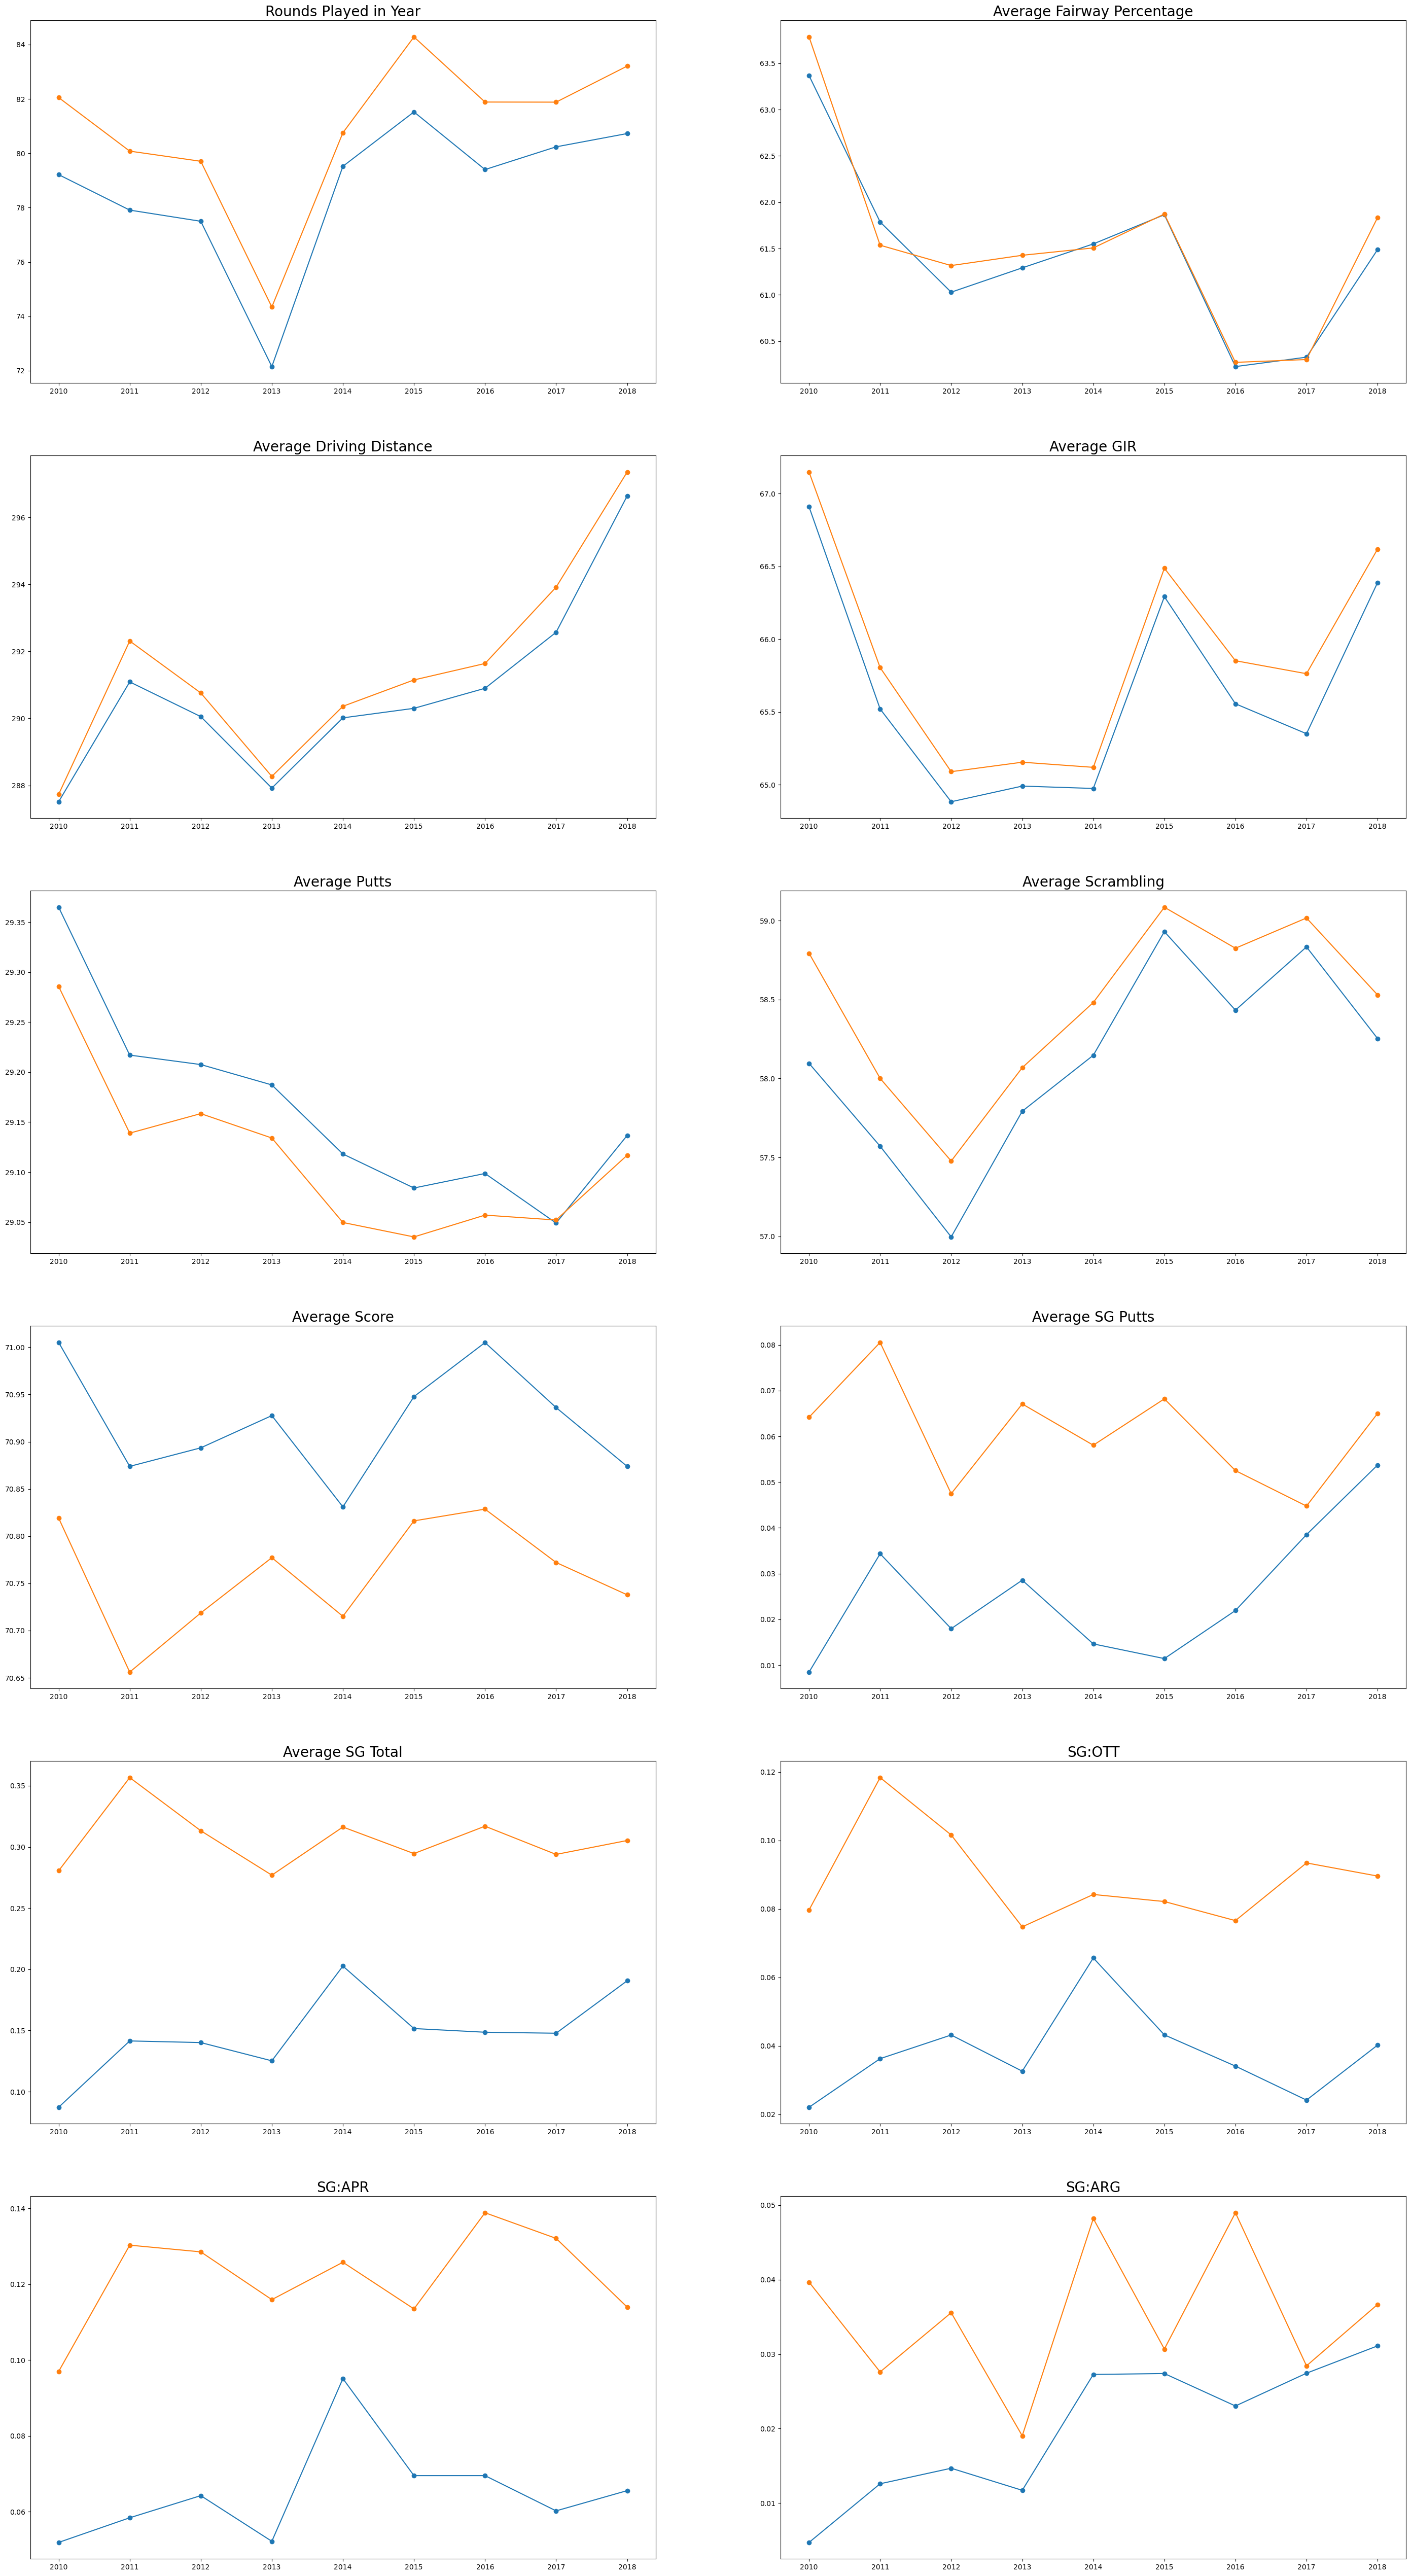

In [11]:
f, ax = plt.subplots(nrows = 6, ncols = 2, figsize=(35,65))
distribution = df.loc[:,df.columns!='Player Name'].columns
distribution = distribution[distribution != 'Year']

rows = 0
cols = 0
lower_better = ['Average Putts', 'Average Score']
for i, column in enumerate(distribution):
    avg = df.groupby('Year')[column].mean()
    best = upperEchelonPlayers.groupby('Year')[column].mean()
    ax[rows,cols].plot(avg, 'o-',)
    ax[rows,cols].plot(best, 'o-',)
    ax[rows,cols].set_title(column, fontsize = 20)
    
    cols += 1
    if cols == 2:
        cols = 0
        rows += 1

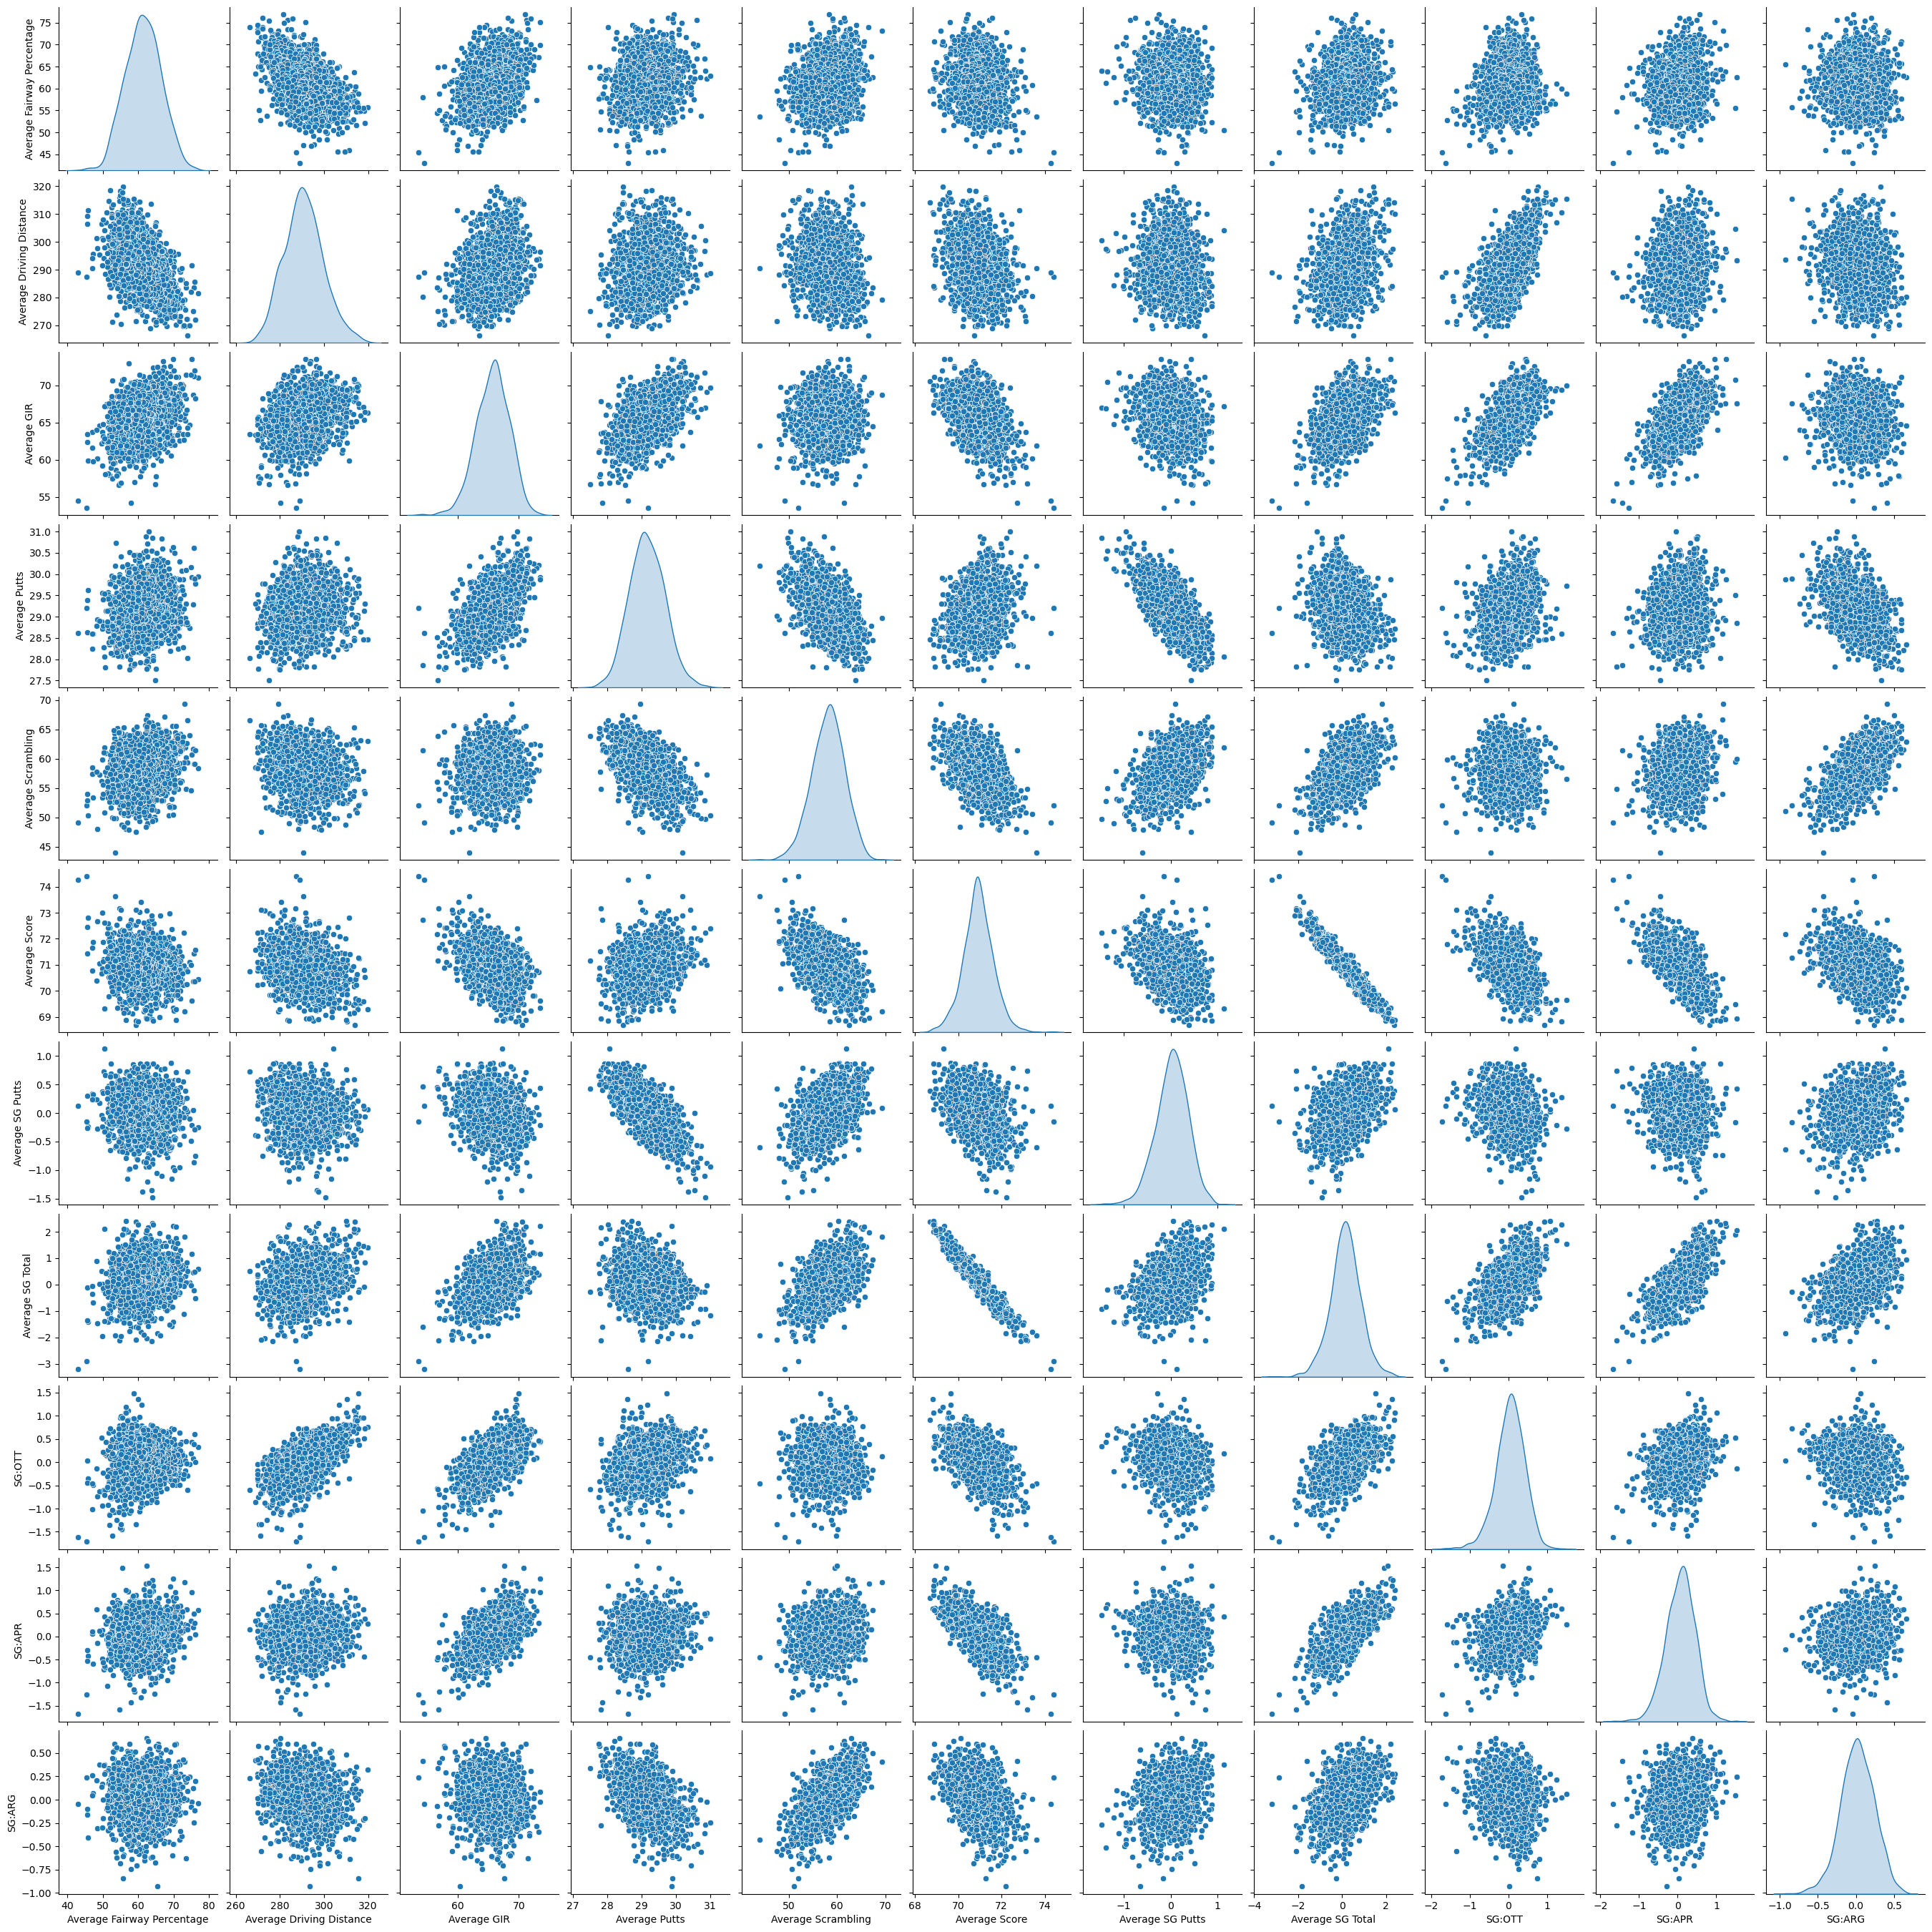

In [12]:
#pairplot graphs to see correlation between features
sns.pairplot(df[['Average Fairway Percentage','Average Driving Distance','Average GIR','Average Putts','Average Scrambling','Average Score','Average SG Putts','Average SG Total','SG:OTT','SG:APR','SG:ARG']], diag_kind='kde')

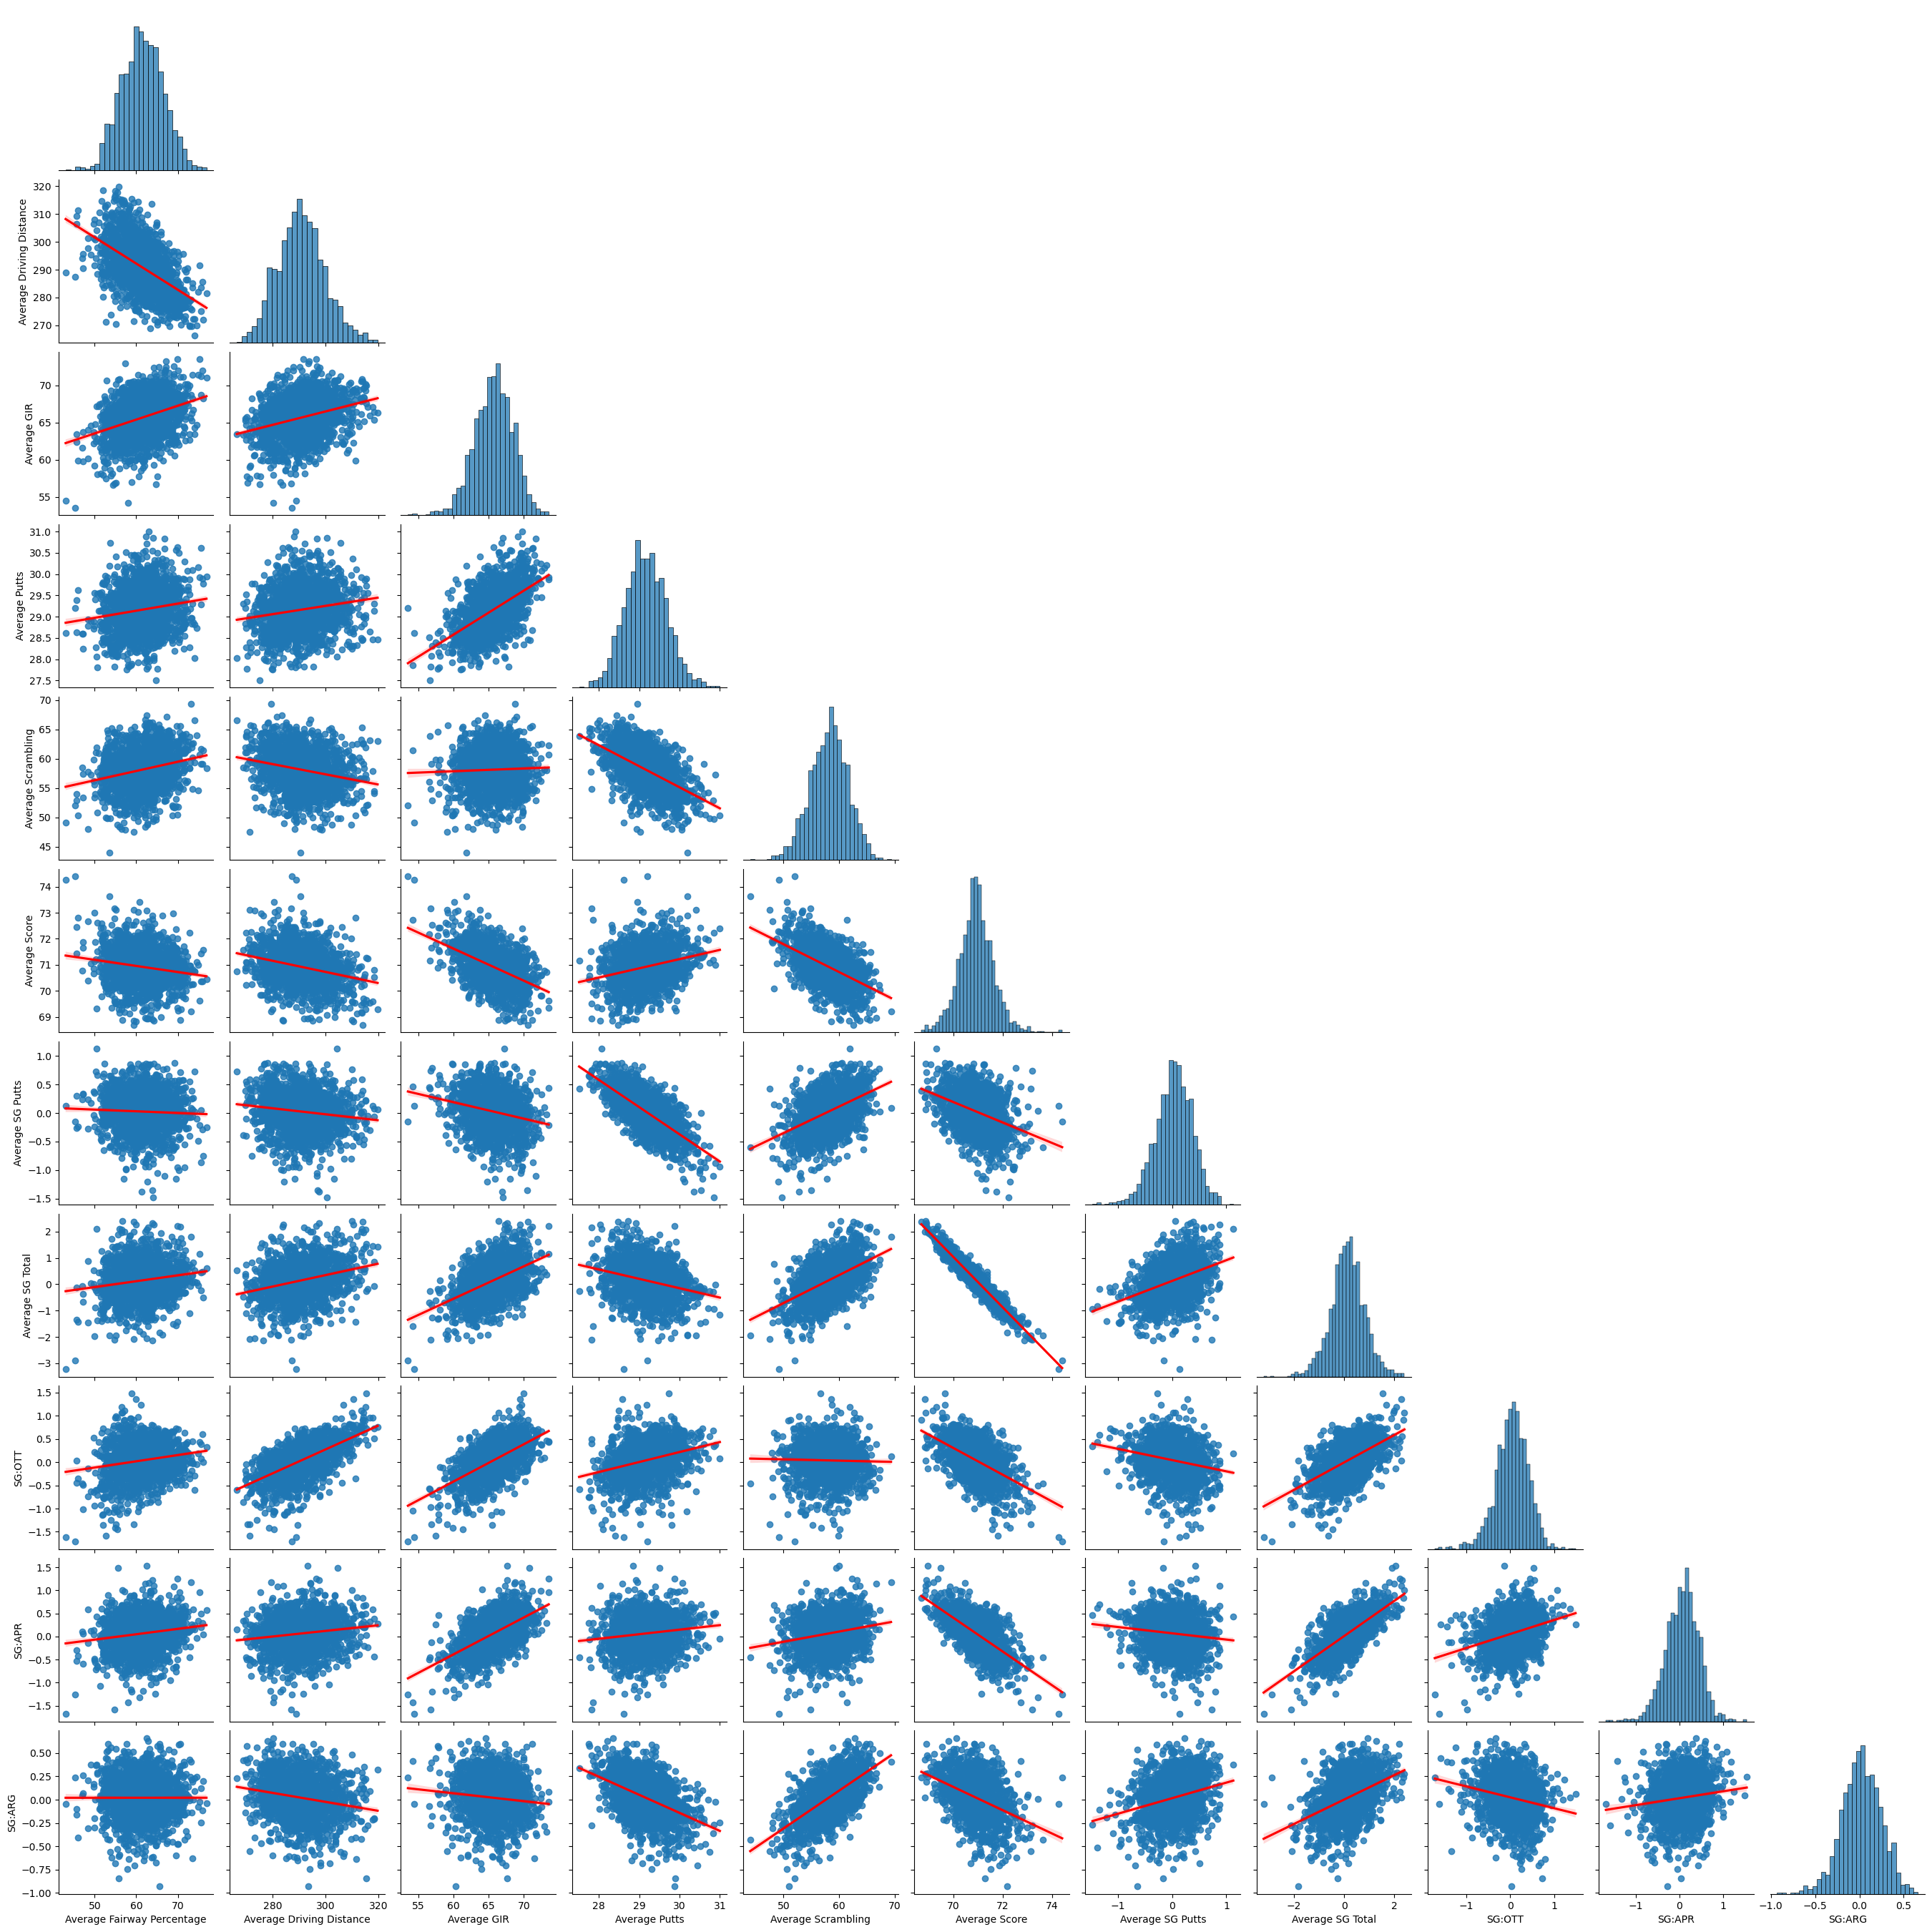

In [13]:
sns.pairplot(df[['Average Fairway Percentage','Average Driving Distance','Average GIR','Average Putts','Average Scrambling','Average Score','Average SG Putts','Average SG Total','SG:OTT','SG:APR','SG:ARG']],kind='reg', corner=True, plot_kws={'line_kws':{'color':'red'}})

In [14]:
train_dataset = df.sample(frac=0.6, random_state=0)
test_dataset = df.drop(train_dataset.index)

In [15]:
#Separating x (all feature columns except target column) and y 
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Top 10 Placements')
test_labels = test_features.pop('Top 10 Placements')


In [16]:
test_features

Year  Rounds Played in Year  Average Fairway Percentage  \
0     2018                     60                       75.19   
3     2018                     78                       71.94   
6     2018                     93                       71.29   
7     2018                     94                       70.16   
11    2018                     94                       69.11   
...    ...                    ...                         ...   
1658  2010                     88                       56.03   
1662  2010                     89                       55.44   
1671  2010                     79                       53.49   
1672  2010                     70                       52.80   
1675  2010                     82                       51.29   

      Average Driving Distance  Average GIR  Average Putts  \
0                        291.5        73.51          29.93   
3                        289.2        68.80          29.17   
6                        295.7        71.09          29.89   
7                        295.2        68.84          29.04   
11                       295.1        71.56          29.67   
...                        ...          ...            ...   
1658                     296.8        67.74          29.11   
1662                     297.3        66.86          29.04   
1671                     291.7        66.51          29.36   
1672                     287.6        61.72          28.97   
1675                     292.9        65.88          29.14   

      Average Scrambling  Average Score  Average SG Putts  Average SG Total  \
0                  60.67         69.617            -0.207             1.153   
3                  64.16         70.015            -0.271             0.941   
6                  54.80         70.404             0.037             0.686   
7                  61.05         70.152             0.546             1.133   
11                 60.93         70.436            -0.250             0.619   
...                  ...            ...               ...               ...   
1658               54.79         71.196             0.215            -0.004   
1662               56.80         70.497             0.409             0.630   
1671               58.86         71.171             0.171            -0.227   
1672               54.20         71.751             0.144            -0.520   
1675               58.46         70.953             0.252             0.093   

      SG:OTT  SG:APR  SG:ARG  player_code  
0      0.427   0.960  -0.027        164.0  
3      0.406   0.532   0.273        343.0  
6      0.378   0.298  -0.027        245.0  
7      0.364   0.345  -0.122        135.0  
11     0.439   0.415   0.014        239.0  
...      ...     ...     ...          ...  
1658  -0.013  -0.065  -0.142        357.0  
1662   0.232   0.064  -0.074        192.0  
1671  -0.233  -0.211   0.044        398.0  
1672  -1.027   0.228   0.130        316.0  
1675  -0.538   0.336   0.047        200.0  

[671 rows x 14 columns]

In [17]:
train_dataset.columns

Index(['Year', 'Rounds Played in Year', 'Average Fairway Percentage',
       'Average Driving Distance', 'Average GIR', 'Average Putts',
       'Average Scrambling', 'Average Score', 'Average SG Putts',
       'Average SG Total', 'SG:OTT', 'SG:APR', 'SG:ARG', 'Top 10 Placements',
       'player_code'],
      dtype='object')

In [18]:
train_labels

1013    2
1110    0
475     2
1319    4
271     2
       ..
1575    0
1185    2
1457    1
382     0
1423    2
Name: Top 10 Placements, Length: 1007, dtype: int32

In [19]:
train_dataset.describe().transpose()

count         mean         std       min  \
Year                        1007.0  2014.010924    2.611886  2010.000   
Rounds Played in Year       1007.0    78.872890   14.371171    45.000   
Average Fairway Percentage  1007.0    61.336634    5.141426    43.020   
Average Driving Distance    1007.0   291.011718    9.097686   268.900   
Average GIR                 1007.0    65.650149    2.750847    53.540   
Average Putts               1007.0    29.172324    0.522625    27.510   
Average Scrambling          1007.0    58.071072    3.383710    44.010   
Average Score               1007.0    70.937447    0.715134    68.698   
Average SG Putts            1007.0     0.020973    0.346637    -1.475   
Average SG Total            1007.0     0.141721    0.706060    -3.209   
SG:OTT                      1007.0     0.042942    0.382708    -1.717   
SG:APR                      1007.0     0.058404    0.385300    -1.680   
SG:ARG                      1007.0     0.019934    0.219986    -0.845   
Top 10 Placements           1007.0     2.327706    2.094644     0.000   
player_code                 1007.0   216.572989  124.258926     0.000   

                                  25%       50%        75%       max  
Year                        2012.0000  2014.000  2016.0000  2018.000  
Rounds Played in Year         68.5000    80.000    89.0000   116.000  
Average Fairway Percentage    57.7050    61.490    64.9050    76.880  
Average Driving Distance     285.0000   290.700   296.7000   319.700  
Average GIR                   63.8200    65.810    67.6100    73.520  
Average Putts                 28.8100    29.150    29.5200    31.000  
Average Scrambling            55.8350    58.270    60.4700    67.160  
Average Score                 70.4840    70.920    71.3680    74.400  
Average SG Putts              -0.1865     0.043     0.2565     1.130  
Average SG Total              -0.2650     0.149     0.5805     2.406  
SG:OTT                        -0.1655     0.059     0.2890     1.367  
SG:APR                        -0.1885     0.077     0.3090     1.533  
SG:ARG                        -0.1260     0.026     0.1695     0.660  
Top 10 Placements              1.0000     2.000     3.0000    12.000  
player_code                  107.5000   215.000   323.5000   438.000

In [20]:
train_features.dtypes

Year                            int64
Rounds Played in Year           int32
Average Fairway Percentage    float64
Average Driving Distance      float64
Average GIR                   float64
Average Putts                 float64
Average Scrambling            float64
Average Score                 float64
Average SG Putts              float64
Average SG Total              float64
SG:OTT                        float64
SG:APR                        float64
SG:ARG                        float64
player_code                   float64
dtype: object

In [48]:
train_features['Year'] = train_features['Year'].astype('float64')
train_features['Rounds Played in Year'] = train_features['Rounds Played in Year'].astype('float64')


In [49]:
np.array(train_features, dtype = 'float64')

array([[ 2.013e+03,  6.500e+01,  6.162e+01, ...,  3.070e-01, -8.300e-02,
         2.520e+02],
       [ 2.012e+03,  9.300e+01,  7.169e+01, ...,  4.270e-01, -1.580e-01,
         1.610e+02],
       [ 2.016e+03,  8.500e+01,  6.032e+01, ..., -3.940e-01,  1.200e-02,
         3.830e+02],
       ...,
       [ 2.011e+03,  7.500e+01,  5.662e+01, ..., -2.360e-01,  3.400e-02,
         2.030e+02],
       [ 2.017e+03,  5.900e+01,  4.537e+01, ..., -1.260e+00,  2.380e-01,
         3.850e+02],
       [ 2.011e+03,  9.800e+01,  5.952e+01, ...,  5.150e-01,  1.390e-01,
         2.450e+02]])

In [50]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [51]:
normalizer.adapt(train_features)

In [52]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',metrics = 'accuracy',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [53]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 14)               29        
 ion)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                960       
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,214
Trainable params: 5,185
Non-trainable params: 29
_________________________________________________________________


In [54]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 58.4 s
Wall time: 6.97 s


In [55]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 2])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Top 10 Placements]')
  plt.legend()
  plt.grid(True)
  

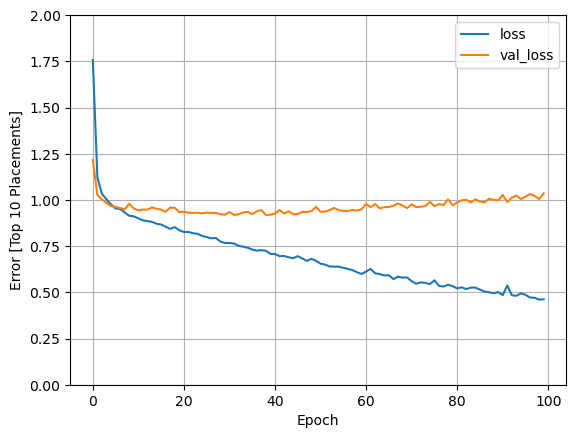

In [56]:
plot_loss(history)

In [62]:
def plot_accuracy(history):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.ylim([0, 1.0])
  plt.xlabel('Epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.grid(True)

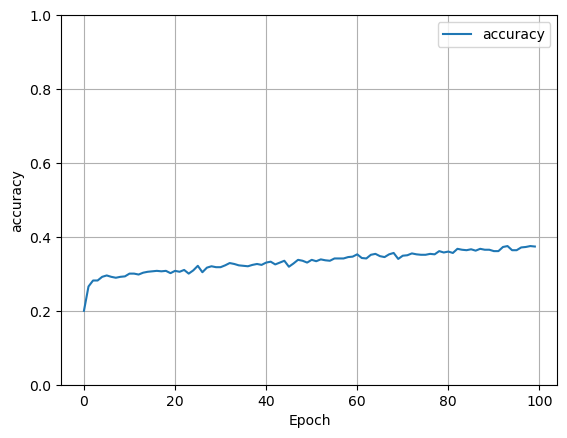

In [63]:
plot_accuracy(history)

In [59]:
test_results = {}

test_results['dnn_model'] = dnn_model.evaluate(
    test_features,
    test_labels, verbose=0)         

In [60]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

21/21 [==============================] - 0s 951us/step


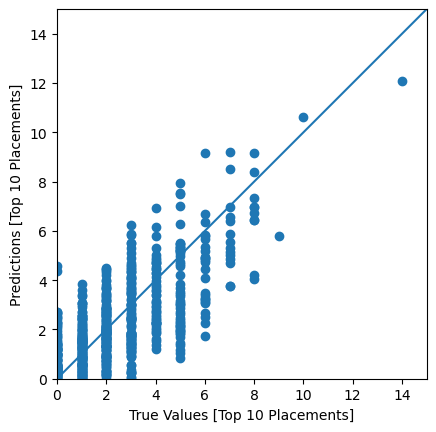

In [61]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Top 10 Placements]')
plt.ylabel('Predictions [Top 10 Placements]')
lims = [0, 15]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)